# Let's Build Personalized Website

Notes: 
1. Use the native Jupyter Notebook to leverage the full features of this notebook
2. Ensure you have Bedrock connection with access to Titan Models 

## 1. Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import base64
import boto3
import io
import os
import json
import re
import importlib
import shutil
import numpy as np
import matplotlib.pyplot as plt

from src import Bedrock

from ipywidgets import widgets
from IPython.core.display import display, HTML
from PIL import Image


In [4]:
importlib.reload(Bedrock)

<module 'src.Bedrock' from '/home/sagemaker-user/GenHVA-Blog/src/Bedrock.py'>

### Useful functions

In [5]:
# fetch context from the response
def get_contexts(retrievalResults):
    total_text = ""
    for result in retrievalResults.get("retrievalResults", []):
        content = result.get("content", {})
        text = content.get("text", "")
        # Remove the metadataAttributes content from the text
        text = re.sub(r'\{.*?metadataAttributes.*?\}', '', text)
        total_text += text
    return total_text

In [6]:
def build_profile(UserProfile):
    profile = 'Your customer is {}. Their industry is {}. They have {} employees. They are a {} company, located in {}.' \
    ' Their mission statement is `{}`.'.format(UserProfile['Name'],
                                UserProfile['Industry'],
                                UserProfile['CompanySize'],
                                UserProfile['CompanyType'],
                                UserProfile['Location'],
                                UserProfile['Mission'])
    return profile

### Decelerations

In [7]:
# create general model inputs 
# do not edit any content in this section

image_modelId = 'amazon.titan-image-generator-v1'
model_id = {'Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
           'Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
           'StableDiff': 'stability.stable-diffusion-xl-v1'}

In [8]:
# ENV VARIABLES
kbId = '<put your knowledge-base ID here>'

### INPUT

Offerings

In [9]:
with open("./references/offerings.json", "r") as file:
    offerings = json.load(file)

User Profiles

In [10]:
Profiles = {
    'Construction-Example': {
        'Name': 'Example Corp Construction',
        'Industry': 'Construction',
        'CompanySize': 1500,
        'CompanyType': 'Enterprise',
        'Location': 'New York City, NY',
        'Mission': 'Building a sustainable future for New York'
    },
    'Manufacturing-Example': {
        'Name': 'Example Corp Manuf',
        'Industry': 'Manufacturing',
        'CompanySize': 2500,
        'CompanyType': 'Enterprise',
        'Location': 'San Jose, CA',
        'Mission': 'Building the next generation Electric Vehicles'
    },
    'Mining-Example': {
        'Name': 'Example Corp Mining',
        'Industry': 'Mining',
        'CompanySize': 500,
        'CompanyType': 'Midsize',
        'Location': 'Bisbee, AZ',
        'Mission': 'Extracting the value for America'
    }
}

Now a user signs in (ITERATION)

In [11]:
# ITERATION - SELECTION:
selected_profile = 'Manufacturing-Example'

In [12]:
UserProfile= Profiles[selected_profile]
offering = offerings[UserProfile['Industry']]
project = selected_profile + "_Website_Haiku"

### Runtime

#### 1) Natural Language description of customer profile

In [13]:
customer = build_profile(UserProfile)
print(customer)

Your customer is Example Corp Manuf. Their industry is Manufacturing. They have 2500 employees. They are a Enterprise company, located in San Jose, CA. Their mission statement is `Building the next generation Electric Vehicles`.


#### 2) Retreieve painpoints of customer industry / any context
This flow uses RAG to retreive documents

In [14]:
query = '{}\nWhat are the possible pain-points and challanges for this customer?'.format(customer)
print(query)

Your customer is Example Corp Manuf. Their industry is Manufacturing. They have 2500 employees. They are a Enterprise company, located in San Jose, CA. Their mission statement is `Building the next generation Electric Vehicles`.
What are the possible pain-points and challanges for this customer?


In [15]:
context_painpoints = Bedrock.dec_retrieve(query, kbId, numberOfResults=10)
contexts_painpoints = get_contexts(context_painpoints)
print(contexts_painpoints)

 To alleviate this burden, there is a need for regulatory reforms that simplify and streamline the regulatory landscape, reducing compliance costs without compromising safety and quality standards. Moreover, manufacturers need to stay abreast of regulatory changes and engage with policymakers to ensure their voices are heard in the regulatory process.  }For example, a mining company might implement on-site water treatment facilities to reduce water consumption or invest in renewable energy sources to power its operations.  Another way mining companies can minimize their impact on the environment is through collaboration with local communities. By engaging with communities affected by mining operations, mining companies can gain a better understanding of their concerns and develop strategies to address them, such as investing in community development programs or implementing measures to protect local ecosystems.  III. Regulatory Uncertainty  Mining companies are also subject to a comple

### 4) Prompting AI to describe a website personalized for this profile and background
Here the prompting is critical. Please see the guidance provided to the LLM. We also ask the response to be in two parts; 1/ Description, 2/ Visual Elements. The second part is needed for an easier traffic move to image generation or finding image.

In [19]:
testimonials = open("./references/Testimonials.txt", "r").read()
print(testimonials)

"AnyCompany Consulting's expert consulting services have been invaluable in streamlining our operations and optimizing our construction processes, resulting in increased efficiency and cost savings" - John Smith, CTO from Example Corp Solutions.

"AnyCompany Consulting's  top-notch consulting solutions have transformed our organization, enabling us to tackle complex challenges, fostering innovation, and propelling our growth to new heights." - Alejandro Rosalez, COO of AnyDepartment Stores.

"AnyCompany Consulting's  strategic advisory services have been instrumental in strengthening our governance frameworks, enhancing transparency, and ensuring compliance with regulatory requirements, facilitating seamless public service delivery." - Jane Doe, Governor of AnyGovernment.


First, we need to get the most recent suggested steps for the LLM

In [20]:
design_steps= open("./references/RecommendedStepsToDesign.txt", "r").read()
print(design_steps)

1. **Header Design:**
   - Choose an attention-grabbing background color and font that aligns with the client's industry.
   - Consider incorporating subtle animations or transitions.

2. **Hero Section:**
   - Select a relevant image that resonates with the customer's profile.
   - Use appropriate text styling and overlays for legibility.
   - Consider incorporating subtle animations or transitions.

3. **Offerings Section:**
   - Identify and prioritize the top 3 most relevant offerings based on the client's pain points and challenges.
   - Create appealing labels and representative icons for each offering.
   - Write a brief explanation for each offering.
   - Icons should be large enough to be visible in different devices.
   - Add an appealing title to the section.

4. **Layout and Presentation:**
   - Present the offerings in an organized and visually appealing layout.
   - Utilize modern CSS techniques for consistent alignment and responsiveness.
   - Consider incorporating subt

In [21]:
design_guideline= open("./references/DesignGuideline.txt", "r").read()

Now, we have all the inputs to form our prompt

In [22]:
prompt = f"""
You are a passionate AI UI/UX designer working for AnyCompany Consulting, a consulting firm that provides management and technical consultancy services to companies in the construction, mining, and manufacturing industries. AnyCompany Consulting now offers personalized online experiences for their registered customers by creating tailored landing pages. These websites feature offerings, design elements, and calls to action that are customized to each customer's profile and industry-specific pain points.

Your task is to design visually appealing and personalized landing pages personalized for customers to encourage them to work with AnyCompany Consulting to get consultancy services. Your response in this activity will be used by artists and front-end developers.

The personalized website should be composed of the following sections:
- A Header
- A Hero Section
- An Offerings Section
- A Customer Pain-points Section
- A Testimonials section 
- A Call-to-Action Section

The website should display the company logo (anycompany_logo.jpg) and the website title is "AnyCompany Consulting Personalized Page". Please also consider adding common menu options on the top.  

The customer testimonials are:
{testimonials}

Please follow the below design guidelines:

{design_guideline}

Your task is to design AnyCompany Consulting landing page website personalized for the below customer:

Customer Profile:
{customer}

Related offerings:
<offerings>
{offering}
</offerings>

Customer challenges and pain-points:
<pain-points>
{contexts_painpoints}
</pain-points>

First, design the personalized website following these steps:

{design_steps}

Now, please provide your response in two sections:

Section 1: Detailed Website Description
This section will be used by front-end developers. Provide a comprehensive and complete description of the personalized website, dynamic content for JavaScript, including the layout, images, sections, and content with full text. Be specific and elaborate in your descriptions. Use labels (e.g. hero-example.jpg) when mentioning images.

Section 2: Visual Elements
This section will be used by artists and designers. Provide a consolidated list of all images with their labels and detailed descriptions. Tag each item with <VISUAL_LABEL> for the label and <VISUAL_DESCRIPTION> for the description, following the provided example format.

Example:

1. <VISUAL_LABEL>hero-image.jpg</VISUAL_LABEL>
<VISUAL_DESCRIPTION>This image depicts a bustling construction site with workers actively engaged in various tasks. In the foreground, there are workers operating heavy machinery, such as excavators and cranes, while others are seen working on scaffolding or carrying materials. The background features a partially constructed building, showcasing the progress of the project.</VISUAL_DESCRIPTION>

2. <VISUAL_LABEL>service-icon.png</VISUAL_LABEL>
<VISUAL_DESCRIPTION>This icon represents the "Pre-Construction Services". It features a blueprint or architectural drawing as the central element, symbolizing the planning and preparation phase of construction projects.</VISUAL_DESCRIPTION>

3. ...
4. ...
"""

In [23]:
%%time
response_personalized_website = Bedrock.invoke(prompt=prompt, modelID=model_id['Haiku'], max_tokens = 4096, temp = 0.0)

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 20.7 s


In [24]:
print(response_personalized_website)

Section 1: Detailed Website Description

Header:
The header section features a clean and modern design with a navy blue background color (#003366) and white text. The AnyCompany Consulting logo is prominently displayed on the left side, while the main navigation menu is positioned on the right. The navigation menu includes the following links: "Home", "Services", "About", "Contact". The header is fixed to the top of the page, ensuring easy access to the navigation throughout the user's experience.

Hero Section:
The hero section showcases a large, high-quality image (hero-example.jpg) that depicts a modern manufacturing facility with various machinery and workers in action. The image is overlaid with a semi-transparent black gradient to improve the readability of the text. The hero section's main heading reads "Transforming Manufacturing Excellence" in a large, bold font (font-size: 48px), and the subheading states "Unlock your full potential with AnyCompany Consulting's tailored solut

#### 5) Image Creation based on Description


##### a) Get the Picture information from the response of the Personalizer LLM
Notice that if the image is "image" then we use 1024 x 1024 otherwise 512 x 512. 

In [20]:
pattern = r'<VISUAL_LABEL>(.+?)</VISUAL_LABEL>\s*<VISUAL_DESCRIPTION>(.+?)</VISUAL_DESCRIPTION>'

# Find all matches in the input string
matches = re.findall(pattern, response_personalized_website, re.DOTALL)


# Create a list of tuples with visual asset name and description
visual_assets= {m[0].strip(): m[1].strip() for m in matches}

# Creating visual assets with the right sizing
visuals = []
for asset in visual_assets.items():
    if "anycompany_logo" in asset[0]:
        continue  # Skip this iteration if the filename contains "unicorn"
    else:
        width = 1024
        height = 1024
    visuals.append({'FileName': asset[0], 'Prompt': asset[1], 'width':width, 'height':height})

In [21]:
print("Number of visual assets created: {}".format(len(visuals)))

Number of visual assets created: 8


##### b) Invoke Stable Diffusion
Here we assumed that the image description is the prompt for Text-to-Image. We successively call the APIs and then save the files.

In [22]:
%%time
responses_image = []
images = []
for vis in visuals:
    response = Bedrock.invoke_stable_diff(prompt = vis['Prompt'],  seed=0, height = vis['height'], 
                                          width = vis['width'], steps = 30, cfg_scale = 10)
    responses_image.append(response)
    image_bytes = base64.b64decode(response.encode('ascii'))

    # Save the image
    image = Image.open(io.BytesIO(image_bytes))
    image.save(f"{vis['FileName']}")
    images.append(np.array(image))

CPU times: user 2.66 s, sys: 25.8 ms, total: 2.69 s
Wall time: 47.5 s


We also copy the company logo from references to next to other visuals for better visibility

In [23]:
shutil.copy("./references/anycompany_logo.jpg", "./anycompany_logo.jpg")

'./anycompany_logo.jpg'

Let's plot the images generated

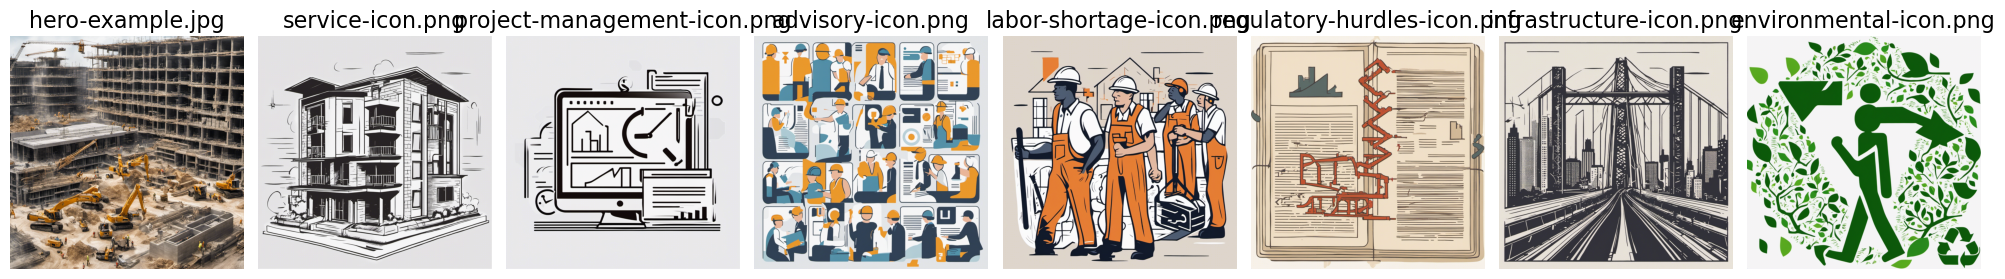

In [24]:
# Plot the images
num_images = len(images)
fig, axs = plt.subplots(1, num_images, figsize=(20, 10))

for i, (image, ax, filename) in enumerate(zip(images, axs, [vis['FileName'] for vis in visuals])):
    ax.imshow(image)
    ax.set_title(filename, fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 6) Let's Generate our HTML file

First, we need to extract the response for the Section 1: Detailed Description from *response_personalized_website*

In [25]:
# Extract Section-1 using regular expressions
#section_1_pattern = r"Section 1: Detailed Website Description\n\n(.*?)\n\nSection 2:"
#match = re.search(section_1_pattern, response_personalized_website, re.DOTALL)

#if match:
#    response_detailed_explanation = match.group(1)
#    print(f"Here is the Section-1 extracted from the LLM response:\n\n{response_detailed_explanation}")
#else:
#    print("Section-1 not found in the input text.")

Here we will use Haiku to create the HTML file.

In [26]:
prompt = f"""
You are an experienced front-end web developer specializing in creating accessible, responsive, and visually appealing websites. Your task is to generate the complete HTML, CSS, and JavaScript code that accurately implements the provided 'Website Description' while adhering to the specified guidelines.

<website description>
Know that, this your Design Guideline (Requirements):
{design_guideline}

You use the testimonials as follows;
{testimonials}

Website Description:
{response_personalized_website}
</website description>

Please carefully read the 'Website Description' line by line, and then generate the HTML, CSS, and JavaScript code required to build the described website while following the specified design guidelines and requirements.

Provide the HTML, CSS, and JavaScript code directly, starting with the <!DOCTYPE html> declaration, without any preamble or introduction.

"""

In [27]:
%%time
response_html = Bedrock.invoke(prompt=prompt, modelID=model_id['Haiku'], max_tokens = 4096, temp = 0)

CPU times: user 4.01 ms, sys: 729 µs, total: 4.74 ms
Wall time: 23.2 s


In [28]:
#print(response_html)

#### Putting the assets into a single folder

In [29]:
#Creating the folder for our project
try:
    os.mkdir(project)
    print(f"Project Folder: {project}")
except Exception as e:
    print(f"An error occurred: {e}")

Project Folder: Construction-Example_Website_Haiku


In [30]:
from IPython.display import HTML

In [31]:
with open('main.html', 'w', encoding='utf-8') as file:
    file.write(response_html)

In [32]:
project_files = list(visual_assets.keys())
project_files.append('main.html')

In [33]:
for file in project_files:
    destination = project + "/" + file
    shutil.move(file, destination)